In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('birds-species-classifier')
jovian.set_colab_id('1d4BpE0J-Q5NMMEjvx8OdSC-SKIbDsxhP')

# Deep Learning Project

I have taken a dataset from *kaggle* which involves images of birds (of 224 X 224 resolution) classified into 400 species. My model, which is based on **ResNet9** architechture, tries to classify the birds into their respective species.

<img src="https://stylesatlife.com/wp-content/uploads/2019/05/different-types-of-birds-with-pictures-and.jpg" width="360">



### Jovian Essentials

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
project_name = 'birds-species-classifier'

In [ ]:
# Execute this to save new versions of the notebook
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/kaushikravibaskar/birds-species-classifier


'https://jovian.ai/kaushikravibaskar/birds-species-classifier'

### Importing all the important necessary modules

In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

### Downloading the Bird Images from Kaggle

In [ ]:
#using opendatasets module to download data from kaggle
!pip install opendatasets
import opendatasets as od

od.download('https://www.kaggle.com/datasets/gpiosenka/100-bird-species')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


100%|██████████| 1.49G/1.49G [01:13<00:00, 21.9MB/s]


### Looking into the downloaded dataset

In [ ]:
dataset_path = './100-bird-species'
print(os.listdir(dataset_path))     #printing all the sub-folders present inside the main dataset folder

birds_species = os.listdir(dataset_path + '/train')
print(birds_species)                #printing all the species of birds given to us

no_birds_species = len(birds_species)
print(no_birds_species)             #printing number of bird species

['test', 'my_csv-2-17-2022-1-17-48.csv', 'class_dict.csv', 'images to test', 'EfficientNetB4-BIRDS-0.99.h5', 'birds latin names.csv', 'valid', 'birds.csv', 'train']
['INCA TERN', 'NORTHERN GANNET', 'KAKAPO', 'INLAND DOTTEREL', 'YELLOW BELLIED FLOWERPECKER', 'ANNAS HUMMINGBIRD', 'CHARA DE COLLAR', 'TEAL DUCK', 'GREAT JACAMAR', 'BLUE HERON', 'CAPE LONGCLAW', 'GOLDEN EAGLE', 'TRUMPTER SWAN', 'GLOSSY IBIS', 'HORNED GUAN', 'CHIPPING SPARROW', 'AMERICAN AVOCET', 'CUBAN TODY', 'CAPE ROCK THRUSH', 'KING VULTURE', 'CALIFORNIA CONDOR', 'VARIED THRUSH', 'GOLDEN CHLOROPHONIA', 'EMPEROR PENGUIN', 'FAIRY TERN', 'GREY PLOVER', 'PEACOCK', 'ROCK DOVE', 'HAWAIIAN GOOSE', 'CROWNED PIGEON', 'PEREGRINE FALCON', 'AMERICAN REDSTART', 'INDIAN PITTA', 'GREEN JAY', 'PELICAN', 'ALTAMIRA YELLOWTHROAT', 'AMERICAN KESTREL', 'ASIAN CRESTED IBIS', 'CRESTED CARACARA', 'RING-NECKED PHEASANT', 'ANTBIRD', 'APOSTLEBIRD', 'OSTRICH', 'IWI', 'RED HEADED WOODPECKER', 'WATTLED CURASSOW', 'EASTERN TOWEE', 'HIMALAYAN MONAL', 'GU

### Producing dataset and dataloaders with all the different optimization strategies like Data Augmentation, Data Normalization.



Creating datasets and dataloaders

In [ ]:
"""
These stats was found by computing mean_and_std of the image train_set after resizing them, after that this stat is used for all test, 
train and val set as it really doesn't matter w.r.t normalization
"""

"""
Images have been resized to 64X64 so as to speed up the computation process without much loss in data accuracy. Also, val_set and test_set are kept seperate as
they should be ideally
"""

stats = ((0.4704, 0.4669, 0.3898), (0.2314, 0.2250, 0.2472))

train_tfms = tt.Compose([tt.Resize((64, 64)), tt.RandomCrop(64, padding=20, padding_mode='reflect'), tt.RandomHorizontalFlip(), tt.ToTensor()])
train_set = ImageFolder(dataset_path + '/train', tt.Compose([train_tfms, tt.Normalize(*stats, inplace=True)]))
val_set = ImageFolder(dataset_path + '/valid', tt.Compose([tt.Resize((64, 64)), tt.ToTensor(), tt.Normalize(*stats, inplace=True)]))

In [ ]:
batch_size = 300

In [ ]:
train_dl = DataLoader(train_set, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(val_set, batch_size*2, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Viewing the images through dataloaders

In [ ]:
def image_original(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def behold_batch(dl):
    for images, labels in dl:
      print(images.size())
      fig, ax = plt.subplots(figsize=(12, 12))
      ax.set_xticks([]); ax.set_yticks([])
      denorm_images = image_original(images, *stats)
      ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
      break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([300, 3, 64, 64])


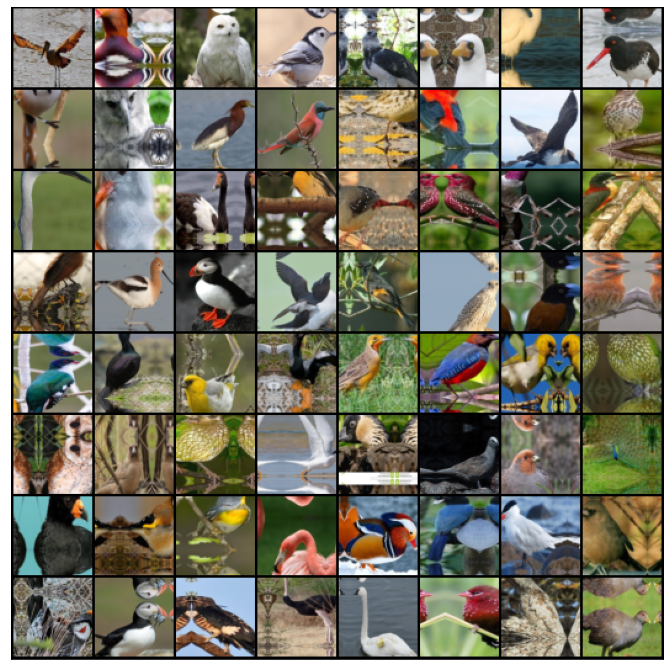

In [ ]:
behold_batch(train_dl)

In [ ]:
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/kaushikravibaskar/birds-species-classifier


'https://jovian.ai/kaushikravibaskar/birds-species-classifier'

### Detecting a GPU and moving all the data on it

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

### Defining the Base Image Classification Model

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

### Defining the Bird Finder Model class based on ResNet-9 Architechture

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class Bird_Finder(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64) # 64 X 64 X 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 X 32 X 32
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128)) # 128 X 32 X 32 
        
        self.conv3 = conv_block(128, 256, pool=True) # 256 X 16 X 16
        self.conv4 = conv_block(256, 512, pool=True) # 512 X 8 X 8
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) # 512 X 8 X 8
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), # 512 X 2 X 2
                                        nn.Flatten(), #2048
                                        nn.Dropout(0.2),
                                        nn.Linear(2048, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(Bird_Finder(3, 400), device)
model

Bird_Finder(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplac

### Defining the Fit-One-Cycle function which will train the model

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history


In [ ]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.0012499999720603228, 'val_loss': 5.9906840324401855}]

### Training the model

In [ ]:
epochs = 20
max_lr = 0.03
grad_clip = 0.05
weight_decay = 1e-5
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.00311, train_loss: 6.4076, val_loss: 5.3729, val_acc: 0.0417
Epoch [1], last_lr: 0.00838, train_loss: 4.8878, val_loss: 3.8371, val_acc: 0.1887
Epoch [2], last_lr: 0.01558, train_loss: 3.9532, val_loss: 2.7625, val_acc: 0.3796
Epoch [3], last_lr: 0.02279, train_loss: 3.3142, val_loss: 2.2434, val_acc: 0.4688
Epoch [4], last_lr: 0.02807, train_loss: 2.8893, val_loss: 2.2011, val_acc: 0.5000
Epoch [5], last_lr: 0.03000, train_loss: 2.5562, val_loss: 1.6103, val_acc: 0.6175
Epoch [6], last_lr: 0.02962, train_loss: 2.4416, val_loss: 1.5848, val_acc: 0.6192
Epoch [7], last_lr: 0.02851, train_loss: 2.1479, val_loss: 1.3081, val_acc: 0.6712
Epoch [8], last_lr: 0.02673, train_loss: 1.9763, val_loss: 1.2551, val_acc: 0.7075
Epoch [9], last_lr: 0.02435, train_loss: 1.8572, val_loss: 0.9708, val_acc: 0.7608
Epoch [10], last_lr: 0.02151, train_loss: 1.7819, val_loss: 1.1930, val_acc: 0.7279
Epoch [11], last_lr: 0.01834, train_loss: 1.5972, val_loss: 0.7908, val_acc: 0.8075
Ep

In [ ]:
train_time='34.23 min'

### Plotting losses, accuracies and learning rate data

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

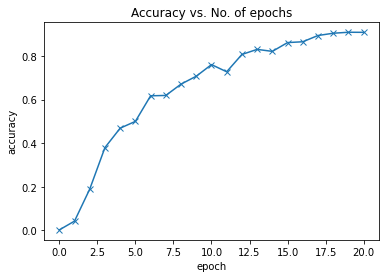

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

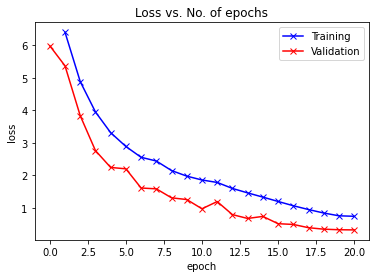

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

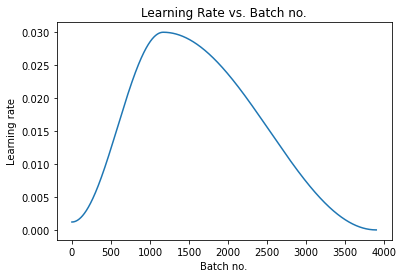

In [ ]:
plot_lrs(history)

### Predicting images from the test dataset

In [ ]:
test_set = ImageFolder(dataset_path + '/test', tt.Compose([tt.Resize((64, 64)), tt.ToTensor(), tt.Normalize(*stats, inplace=True)]))
test_loader = DataLoader(test_set, batch_size, num_workers=3, pin_memory=True)
test_loader = DeviceDataLoader(test_loader, device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_set.classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: ABBOTTS BABBLER , Predicted: ABBOTTS BABBLER


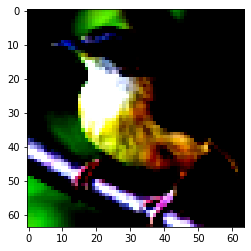

In [ ]:
img, label = test_set[2]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_set.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: ALBERTS TOWHEE , Predicted: ALBERTS TOWHEE


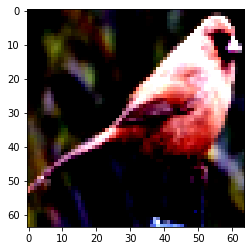

In [ ]:
img, label = test_set[43]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_set.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: ANDEAN GOOSE , Predicted: ANDEAN GOOSE


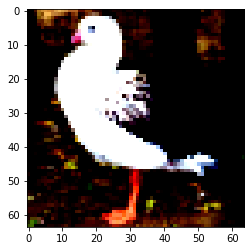

In [ ]:
img, label = test_set[101]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_set.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: AMERICAN KESTREL , Predicted: AMERICAN KESTREL


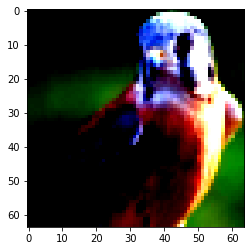

In [ ]:
img, label = test_set[82]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_set.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
#finding loss and accuracy on test dataset
test_result = evaluate(model, test_loader)
test_result

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.9345237016677856, 'val_loss': 0.22802521288394928}

### Identifying labels to Images to Test section

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: AFRICAN FIREFINCH


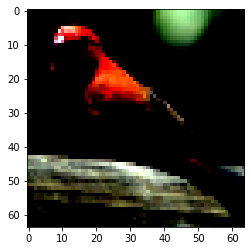

In [ ]:
from PIL import Image

im = Image.open(dataset_path + '/images to test/1.jpg')
im = tt.Compose([tt.Resize((64, 64)), tt.ToTensor(), tt.Normalize(*stats, inplace=True)])(im)
plt.imshow(im.permute(1, 2, 0))
print('Predicted:', predict_image(im, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: AFRICAN CROWNED CRANE


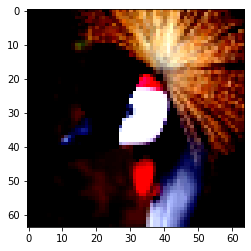

In [ ]:
im = Image.open(dataset_path + '/images to test/14.jpg')
im = tt.Compose([tt.Resize((64, 64)), tt.ToTensor(), tt.Normalize(*stats, inplace=True)])(im)
plt.imshow(im.permute(1, 2, 0))
print('Predicted:', predict_image(im, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: AFRICAN CROWNED CRANE


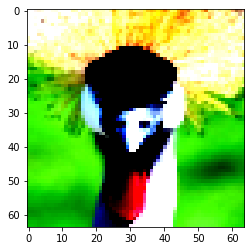

In [ ]:
im = Image.open(dataset_path + '/images to test/2.jpg')
im = tt.Compose([tt.Resize((64, 64)), tt.ToTensor(), tt.Normalize(*stats, inplace=True)])(im)
plt.imshow(im.permute(1, 2, 0))
print('Predicted:', predict_image(im, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: AFRICAN CROWNED CRANE


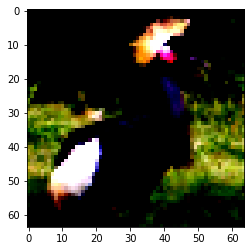

In [ ]:
im = Image.open(dataset_path + '/images to test/3.jpg')
im = tt.Compose([tt.Resize((64, 64)), tt.ToTensor(), tt.Normalize(*stats, inplace=True)])(im)
plt.imshow(im.permute(1, 2, 0))
print('Predicted:', predict_image(im, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: AFRICAN CROWNED CRANE


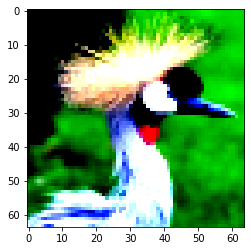

In [ ]:
im = Image.open(dataset_path + '/images to test/4.jpg')
im = tt.Compose([tt.Resize((64, 64)), tt.ToTensor(), tt.Normalize(*stats, inplace=True)])(im)
plt.imshow(im.permute(1, 2, 0))
print('Predicted:', predict_image(im, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: AFRICAN CROWNED CRANE


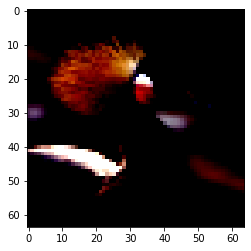

In [ ]:
im = Image.open(dataset_path + '/images to test/5.jpg')
im = tt.Compose([tt.Resize((64, 64)), tt.ToTensor(), tt.Normalize(*stats, inplace=True)])(im)
plt.imshow(im.permute(1, 2, 0))
print('Predicted:', predict_image(im, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: ANTBIRD


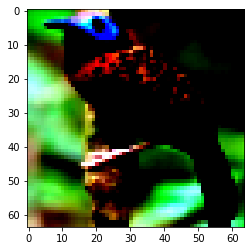

In [ ]:
im = Image.open(dataset_path + '/images to test/7.jpg')
im = tt.Compose([tt.Resize((64, 64)), tt.ToTensor(), tt.Normalize(*stats, inplace=True)])(im)
plt.imshow(im.permute(1, 2, 0))
print('Predicted:', predict_image(im, model))

### Conclusion

Hence, after trying out the model with different hyperparameters, it can be seen that the model can be trained better if no. of epochs are increased. However, the model will give different result for variations in value of other hyperparameters like learning rate, weight-decay etc.

ResNet9 Architechture is by far the best architechture w.r.t the simple regression, feed-forward NN and CNN based architechture as it takes into account the factors which generally leads to overfitting and tackles them by methods like BatchNorm, Dropouts, 

### Saving the model and logging the hyperparams

In [ ]:
torch.save(model.state_dict(), 'birdfinder.pth')

In [ ]:
jovian.reset()
jovian.log_hyperparams(arch='resnet9', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Hyperparams logged.


In [ ]:
jovian.log_metrics(test_loss=test_result['val_loss'], 
                   test_acc=test_result['val_acc'],
                   train_loss=history[-1]['train_loss'],
                   time=train_time)

[jovian] Metrics logged.


In [ ]:
jovian.commit(project=project_name, outputs=['birdfinder.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/kaushikravibaskar/birds-species-classifier


'https://jovian.ai/kaushikravibaskar/birds-species-classifier'